# Differential Expression Analysis 

In [2]:
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from bioinfokit.visuz import GeneExpression

In [3]:
# Load RNA-seq dataset and metadata
data = pd.read_csv('../data/processed/SRP053101/SRP053101.tsv', sep='\t')
metadata = pd.read_csv('../data/processed/SRP053101/metadata_SRP053101.tsv', sep='\t')

expression_df = data.set_index(data.columns[0])

metadata['timepoint'] = metadata['refinebio_title'].apply(
    lambda x: 'T0' if x.endswith('_T0') else 'T3'
)

expression_samples = expression_df.columns.tolist()
metadata_filtered = metadata[metadata['refinebio_accession_code'].isin(expression_samples)].copy()
metadata_filtered = metadata_filtered.set_index('refinebio_accession_code').loc[expression_samples].reset_index()
expression_df = expression_df[metadata_filtered['refinebio_accession_code']]

print(f"Dataset loaded: {expression_df.shape[0]:,} genes, {expression_df.shape[1]} samples")

Dataset loaded: 43,355 genes, 88 samples


In [4]:
# Prepare count matrix and metadata for PyDESeq2
counts_df = expression_df.round().astype(int)
metadata_pydeseq = metadata_filtered.set_index('refinebio_accession_code')
metadata_pydeseq['timepoint'] = pd.Categorical(
    metadata_pydeseq['timepoint'], 
    categories=['T0', 'T3'], 
    ordered=True
)

print("Data prepared for PyDESeq2")

Data prepared for PyDESeq2


In [5]:
# Create PyDESeq2 DataSet and run analysis
counts_transposed = counts_df.T

dds = DeseqDataSet(
    counts=counts_transposed,
    metadata=metadata_pydeseq,
    design_factors="timepoint"
)

print("Running DESeq2 analysis...")
dds.deseq2()
print("DESeq2 analysis completed")

Running DESeq2 analysis...
Using None as control genes, passed at DeseqDataSet initialization


/var/folders/_v/n41tz8z95n74x67p4npp6ndc0000gn/T/ipykernel_18524/1389261094.py:4: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.06 seconds.

Fitting dispersions...
Fitting dispersions...
... done in 1.29 seconds.

Fitting dispersion trend curve...
... done in 1.29 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 2.77 seconds.

Fitting LFCs...
... done in 2.77 seconds.

Fitting LFCs...
... done in 1.31 seconds.

Calculating cook's distance...
... done in 0.10 seconds.

Replacing 1 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 1.31 seconds.

Calculating cook's distance...
... done in 0.10 seconds.

Replacing 1

DESeq2 analysis completed


... done in 0.06 seconds.



In [6]:
# Extract differential expression results with shrinkage
stat_res = DeseqStats(dds, contrast=('timepoint', 'T3', 'T0'))
stat_res.summary()

# Apply log fold change shrinkage
stat_res.lfc_shrink(coeff="timepoint[T.T3]")

# Extract shrunken results and prepare final dataframe
results_df = stat_res.results_df.copy()
final_results = results_df.copy()
final_results['gene'] = final_results.index
final_results = final_results.reset_index(drop=True)
final_results['significant'] = (final_results['padj'] < 0.05) & (~final_results['padj'].isna())
final_results = final_results.sort_values('padj').reset_index(drop=True)

print(f"Results extracted with shrinkage applied: {len(results_df):,} genes")
print(f"Significant genes: {final_results['significant'].sum():,}")

try:
    import json
    with open('../results/ensembl_to_symbol_mapping.json', 'r') as f:
        gene_mapping_dict = json.load(f)
    
    gene_mapping = pd.DataFrame([
        {'ensembl_id': ensembl_id, 'gene_symbol': symbol} 
        for ensembl_id, symbol in gene_mapping_dict.items()
    ])

    final_results['gene_symbol'] = final_results['gene'].map(gene_mapping_dict)
    
    final_results['gene_symbol'] = final_results['gene_symbol'].fillna(final_results['gene'])
    
    cols = ['gene', 'gene_symbol'] + [col for col in final_results.columns if col not in ['gene', 'gene_symbol']]
    final_results = final_results[cols]
    
    print(f"Mapped {(~final_results['gene_symbol'].eq(final_results['gene'])).sum():,} genes to symbols")
    
except FileNotFoundError:
    print("Gene mapping file not found. Using ENSEMBL IDs only.")
    final_results['gene_symbol'] = final_results['gene'] 
except Exception as e:
    print(f"Error loading gene mapping: {e}")
    final_results['gene_symbol'] = final_results['gene']

Running Wald tests...
... done in 1.01 seconds.

Fitting MAP LFCs...
... done in 1.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: timepoint T3 vs T0
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene                                                                       
ENSG00000000003   6.932265        0.066447  0.118496  0.560752  0.574967   
ENSG00000000005  10.920938       -0.456968  0.116219 -3.931948  0.000084   
ENSG00000000419   3.670752       -0.026585  0.162501 -0.163602  0.870045   
ENSG00000000457   2.988860        0.011185  0.179946  0.062159  0.950437   
ENSG00000000460   2.000149        0.000214  0.219849  0.000974  0.999223   
...                    ...             ...       ...       ...       ...   
ENSG00000285498   0.000000             NaN       NaN       NaN       NaN   
ENSG00000285505   0.613711       -0.106651  0.486160 -0.219374  0.826359   
ENSG00000285508   1.852422        0.017916  0.228557  0.078389  0.937518   
ENSG00000285509   0.954620        0.068927  0.318211  0.216607  0.828514   
ENSG00000285513   0.000000     

... done in 2.76 seconds.



Shrunk log2 fold change & Wald test p-value: timepoint[T.T3]
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene                                                                       
ENSG00000000003   6.932265        0.003849  0.039525  0.560752  0.574967   
ENSG00000000005  10.920938       -0.388226  0.121957 -3.931948  0.000084   
ENSG00000000419   3.670752       -0.000810  0.040084 -0.163602  0.870045   
ENSG00000000457   2.988860        0.000289  0.040304  0.062159  0.950437   
ENSG00000000460   2.000149        0.000005  0.040636  0.000974  0.999223   
...                    ...             ...       ...       ...       ...   
ENSG00000285498   0.000000             NaN       NaN       NaN       NaN   
ENSG00000285505   0.613711       -0.000387  0.040947 -0.219374  0.826359   
ENSG00000285508   1.852422        0.000289  0.040696  0.078389  0.937518   
ENSG00000285509   0.954620        0.000588  0.041030  0.216607  0.828514   
ENSG00000285513   0.000000 

In [40]:
print("Top 50 significant genes:")
print(final_results[final_results['significant']].head(50)[['gene', 'gene_symbol', 'log2FoldChange', 'padj']])  

Top 50 significant genes:
               gene gene_symbol  log2FoldChange          padj
0   ENSG00000164128       NPY1R       -0.524289  1.053927e-08
1   ENSG00000145423       SFRP2       -1.091122  1.247040e-08
2   ENSG00000116133      DHCR24       -0.609263  4.129973e-08
3   ENSG00000113083         LOX       -0.599049  4.129973e-08
4   ENSG00000174697         LEP       -0.310507  1.112259e-07
5   ENSG00000137713     PPP2R1B       -0.528475  1.739044e-07
6   ENSG00000075223      SEMA3C       -0.535434  1.739044e-07
7   ENSG00000109107       ALDOC       -0.745998  4.525731e-07
8   ENSG00000104763       ASAH1       -0.308070  4.525731e-07
9   ENSG00000101825       MXRA5       -0.899241  5.435838e-07
10  ENSG00000119927        GPAM       -0.550713  5.635271e-07
11  ENSG00000122176        FMOD       -0.475300  1.920517e-06
12  ENSG00000151365       THRSP       -0.348789  3.085678e-06
13  ENSG00000113389        NPR3       -0.452989  3.251552e-06
14  ENSG00000000971         CFH       -0.501

In [41]:
# Save results
final_results.to_csv('../results/differential_expression_results_T3_vs_T0_complete.csv', index=False)

significant_genes = final_results[final_results['significant']].copy()
significant_genes.to_csv('../results/significant_genes_T3_vs_T0.csv', index=False)

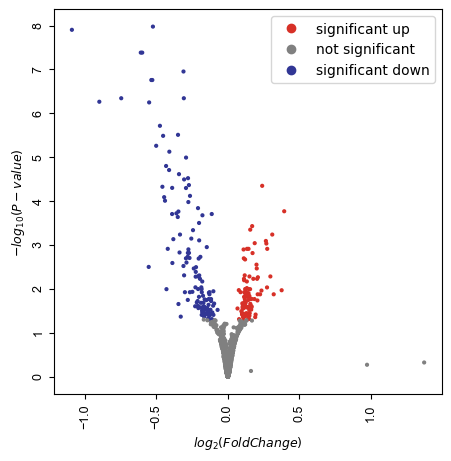

In [ ]:
# Create volcano plot using bioinfokit
from bioinfokit import visuz

# Prepare data for bioinfokit with proper cleaning
volcano_data_biokit = final_results.copy()
volcano_data_biokit = volcano_data_biokit.rename(columns={'gene': 'gene_id'})

volcano_data_biokit = volcano_data_biokit.dropna(subset=['log2FoldChange', 'padj'])
volcano_data_biokit = volcano_data_biokit[
    ~volcano_data_biokit['log2FoldChange'].isin([np.inf, -np.inf]) &
    ~volcano_data_biokit['padj'].isin([np.inf, -np.inf])
]

visuz.GeneExpression.volcano(
    df=volcano_data_biokit, 
    lfc='log2FoldChange',
    pv='padj',
    lfc_thr=(0.0, 0.0),   
    pv_thr=(0.05, 0.05),   
    geneid='gene_id',
    genenames='gene_id',
    plotlegend=True,
    legendpos='upper right',
    figname='volcano_plot_bariatric_rna_seq',
    dotsize=4,                        
    color=('#d73027', '#808080', '#313695'),  
    show=True
)
